In [8]:
import numpy as np
from matplotlib import pyplot as plt

# Generate Ground Truth Features and Data

In [9]:
n = 1000 #rows
p = 500 #columns

#is this just a random sample of 'p' elements in a normal distribution
x_true = np.random.normal(size=(p,))

# Normalize x_true
# Makes this into a unit vector
# "contain the normalized version of its original values, ensuring that its Euclidean norm becomes 1."
x_true /= np.linalg.norm(x_true)

#generates a random matrix with n rows and p columns, where each element follows a standard normal distribution
#divide each element by sqrt(p) to scale down the cells
A = np.random.normal(size=(n,p)) / np.sqrt(p)

#@ = matrix multiplication
#Ax = b, where x_true is the weights matrix
#b is the output vector
b = A @ x_true

#returns single value, s, of the single value decomposition of "A"
_, s, _ = np.linalg.svd(A)

print(f'The Max SinVal of A is {s[0]:.3f}')

diag_max = np.max(np.diag(A.T @ A))
print(f'The Max DiagVal of A is {diag_max:.3f}')

The Max SinVal of A is 2.384
The Max DiagVal of A is 2.305


# Some Useful Definitions

In [10]:

#alpha is the fraction (0-1) of expected number of non-zeroes
#represents 
def sample_mask(alpha, shape):
    return np.random.choice(2, size=shape, p=[1 - alpha, alpha]) / alpha

#linear regression loss
def loss(A, b, x):
    return 0.5 * np.linalg.norm(A @ x - b) ** 2

# loss function from dropout
# "The dropout solves the following optimization problem"
def masked_loss(A, b, x, mask):
    return loss(A, b, (x * mask))

#error between given mask and x_true
def err(x):
    return np.linalg.norm(x - x_true)

# 
def masked_err(x, mask):
    return err(x * mask)


def reg(A, x, alpha):
    return 0.5 * (1 / alpha - 1) * np.inner(x, np.diag(A.T @ A) * x)


def masked_reg(A, x, alpha, mask):
    return reg(A, x * mask, alpha)


def loss_grad(A, b, x):
    return A.T @ (A @ x - b)

# ----
def masked_grad(A, b, x, mask):
    return mask * loss_grad(A, b, mask * x)
#-----

def reg_grad(A, x, alpha):
    return (1 / alpha - 1)  * np.diag(A.T @ A) * x


def masked_reg_grad(A, x, alpha, mask):
    return mask * reg_grad(A, mask * x, alpha)



# Verify Solutions of Dropout and Regularized GD

In [11]:
def gd(A, b, x_init, eta, num_iter):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x -= eta * loss_grad(A, b, x)
        x_hist[i] = np.copy(x)
    return x_hist


def dereg_dropout(A, b, x_init, eta, alpha, num_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        grad_agg = np.zeros_like(x)
        for _ in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            grad_agg += masked_grad(A, b, x, mask) - alpha * masked_reg_grad(A, x, alpha, mask)
        x -= eta / num_masks * grad_agg
        x_hist[i] = np.copy(x)
    return x_hist


def reg_GD(A, b, x_init, eta, alpha, num_iter):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x -= eta * (loss_grad(A, b, x) + reg_grad(A, x, alpha))
        x_hist[i] = np.copy(x)
    return x_hist


def dropout(A, b, x_init, eta, alpha, num_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        grad_agg = np.zeros_like(x)
        for _ in range(num_masks):
            grad_agg += masked_grad(A, b, x, sample_mask(alpha, x.shape))
        x -= eta / num_masks * grad_agg
        x_hist[i] = np.copy(x)
    return x_hist

Stepsize: 0.176
lowest 0.005406173683043116


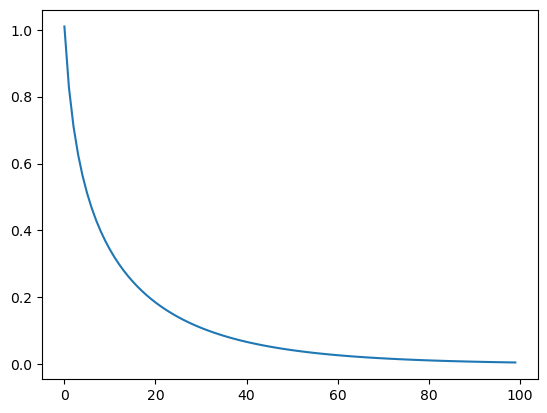

In [12]:
# Generate an initialization
x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

# Set parameters
num_iter = 100
alpha = 0.3
eta = 1 / s[0] ** 2 # 1/L step size
print(f'Stepsize: {eta:.3f}')

gd_hist = gd(A, b, x_init, eta, num_iter)
gd_err = [err(gd_hist[i]) for i in range(num_iter)]
print("lowest", gd_err[-1])

plt.plot(np.arange(num_iter), gd_err)
plt.show()

## Notice

Dropout solution is close to RegGD solution when the number of masks is large (concentration property). If the number of masks is small, we could potentially use a smaller stepsize

# Remove Regularization from Dropout

Each worker here should solve

$$\min_{\mathbf{x}}\frac{1}{2}\left\|\mathbf{A}(\mathbf{m}\odot\mathbf{x}) - \mathbf{b}\right\|_2^2 - \frac{1 - \alpha}{2}\langle\mathbf{m}\odot\mathbf{x}, \mathbf{m}\odot(\mathbf{v}\odot\mathbf{x})\rangle$$

The gradient is given by

$$\nabla = \mathbf{m}\odot(\mathbf{A}^\top(\mathbf{A}(\mathbf{m}\odot\mathbf{x}) - \mathbf{b}) - (1 - \alpha)(\mathbf{m}\odot\mathbf{m}\odot\mathbf{v}\odot\mathbf{x})$$

# More than One Local Steps

In [31]:
#new function that aligns w theory (?)
def dereg_dropout_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B_sv = np.linalg.norm(A @ (mask * alpha), 2)
            local_eta = 1 / B_sv[0] ** 2
            x_in = np.copy(x)
        
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

def dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

In [ ]:
# Set parameters
num_iter = 10 #global iterations
# 1 / (5L)
eta = .2 / s[0] ** 2 # 1/L step size #lischpitz constant
num_masks = 20


print("eta", eta)

plt.figure(figsize=(10, 8))
# ----------------------------------------------------------------------
alpha = .8

ax1 = plt.subplot(131) #1 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 1, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax1.plot(np.arange(num_iter), dereg_local_err, label='local = 1')

ax1 = plt.subplot(131) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 5, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax1.plot(np.arange(num_iter), dereg_local_err, label='5')

ax1 = plt.subplot(131) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 10, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax1.plot(np.arange(num_iter), dereg_local_err, label='10')

ax1 = plt.subplot(131) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 50, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax1.plot(np.arange(num_iter), dereg_local_err, label='50')

ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Alpha=0.8')

# ----------------------------------------------------------------------
alpha = .5

ax2 = plt.subplot(132) #1 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 1, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax2.plot(np.arange(num_iter), dereg_local_err, label='local = 1')

ax2 = plt.subplot(132) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 5, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax2.plot(np.arange(num_iter), dereg_local_err, label='5')

ax2 = plt.subplot(132) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 10, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax2.plot(np.arange(num_iter), dereg_local_err, label='10')

ax2 = plt.subplot(132) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 50, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax2.plot(np.arange(num_iter), dereg_local_err, label='50')

ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Alpha=0.5')

# ----------------------------------------------------------------------
alpha = .3

ax3 = plt.subplot(133) #1 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 1, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax3.plot(np.arange(num_iter), dereg_local_err, label='local = 1')

ax3 = plt.subplot(133) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 5, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax3.plot(np.arange(num_iter), dereg_local_err, label='5')

ax3 = plt.subplot(133) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 10, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax3.plot(np.arange(num_iter), dereg_local_err, label='10')

ax3 = plt.subplot(133) #5 local iteration
dereg_local_hist = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 50, num_masks)
dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
ax3.plot(np.arange(num_iter), dereg_local_err, label='50')

ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Alpha=0.3')

t = str(eta)
plt.yscale('log')
plt.show()
#lischopilize 

In [ ]:
# Generate an initialization
x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

# Set parameters
alpha = 0.5
num_iter = 100

plt.figure(figsize=(12,5))
ax1 = plt.subplot(161)
ax2 = plt.subplot(162)
ax3 = plt.subplot(163)
ax4 = plt.subplot(164)
ax5 = plt.subplot(165)

## Regular Gradient Descent
gd_hist = gd(A, b, x_init, eta, num_iter)
gd_err = [err(gd_hist[i]) for i in range(num_iter)]

ax1.set_title('Gradient descent')
ax1.plot(np.arange(num_iter), gd_err)
ax1.set_yscale('log')

## Gradient Descent using masks
num_masks = 200
dropout_hist = dropout(A, b, x_init, eta, alpha, num_iter, num_masks)
dropout_err = [err(dropout_hist[i]) for i in range(num_iter)]

ax2.set_title('Blind dropout')
ax2.plot(np.arange(num_iter), dropout_err)
ax2.set_yscale('log')

## Sanity check that Dropout GD is just GD on a regularized objective
reg_gd_hist = reg_GD(A, b, x_init, eta, alpha, num_iter)
reg_gd_err = [err(reg_gd_hist[i]) for i in range(num_iter)]

ax3.set_title('Sanity: Regularized GD')
ax3.plot(np.arange(num_iter), reg_gd_err)
ax3.set_yscale('log')

## Deregularized GD
dereg_dropout_hist = dereg_dropout(A, b, x_init, eta, alpha, num_iter, num_masks)
dereg_dropout_err = [err(dereg_dropout_hist[i]) for i in range(num_iter)]

ax4.set_title('Deregularized Dropout')
ax4.plot(np.arange(num_iter), dereg_dropout_err)
ax4.set_yscale('log')

num_iter = 250
## Deregularized GD with manual step size
dereg_dropout_hist2 = dereg_dropout(A, b, x_init, eta/5, alpha, num_iter, num_masks)
dereg_dropout_err2 = [err(dereg_dropout_hist2[i]) for i in range(num_iter)]

ax5.set_title('Deregularized dropout 2')
ax5.plot(np.arange(num_iter), dereg_dropout_err2)
ax5.set_yscale('log')

Before testing with local stepsizes, I wanted to try and see the effects of the hyperparamters on the functions. I first tested on dereg_dropout and blind dropout using n = 1000, p = 500, alpha = .05, 200 global iterations, and 1/L stepsize.

In [ ]:
n = 1000 #rows
p = 500 #columns

num_masks = [20, 50, 100, 250]
num_iter = 200

alphas = .5
eta = 1 / s[0] ** 2 # 1/L step size

print(f'Stepsize: {eta:.3f}')

num_masks = [20, 50, 100, 250]

# Generate an initialization
x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

# Set parameters
alpha = 0.5

plt.figure(figsize=(18,9))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for num_masks_idx in range(len(num_masks)):
    dereg_dropout_hist = dereg_dropout(A, b, x_init, eta, alpha, num_iter, num_masks[num_masks_idx])
    dereg_dropout_err = [err(dereg_dropout_hist[i]) for i in range(num_iter)]

    print("Dereg Dropout w/", num_masks[num_masks_idx], "masks - Err:", round(dereg_dropout_err[-1], 3))

    ax1.plot(np.arange(num_iter), dereg_dropout_err, label= f'# masks = {num_masks[num_masks_idx]}')

    blind_dropout_hist = dropout(A, b, x_init, eta, alpha, num_iter, num_masks[num_masks_idx])
    blind_dropout_err = [err(blind_dropout_hist[i]) for i in range(num_iter)]

    print("Blind Dropout w/", num_masks[num_masks_idx], "masks - Err:", round(blind_dropout_err[-1], 3))
    print("-----------")

    ax2.plot(np.arange(num_iter), blind_dropout_err, label= f'# masks = {num_masks[num_masks_idx]}')

ax1.set_yscale('log')
ax1.set_xlabel('Global Outer')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Dereg Dropout: Vary Masks (1000 x 500)')

ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel('Global Outer')
ax2.set_ylabel('Error')
ax2.set_title('Blind Dropout: Vary Masks')

(Before my 200 global iter experiment, I actually ran on 10 global iter and got small errors but was curious to see on bigger global iter). What I could tell from these graphs and accuracies is that dereg_dropout's accuracy levels out slower when its # of masks is high (rate of chance in accuracy is dependent on # masks). Not only does the accuracy level out slower, but it is also lower. I think that dereg_dropout might get lower accuracy is # masks is very high, but I think it might reach a threshold. On the other hand, blind dropout's accuracy stays stagnant no matter the number of masks and rate of decrease is independent of # of masks. (Running time: 16 min)

To get lower accuracy, I tried to test Professor Tasos' claim that bigger dimensions results in lower accuracy, so I doubled the original dimensions to 4000 x 2000, which is greater than Professor Tasos' experiment. All the other parameters were the same compared to the above experiment (1/L, 200 global, .5 alpa, # masks varying).

In [ ]:
n = 4000 #rows
p = 2000 #columns

num_masks = [20, 50, 100, 250]
num_iter = 200
alphas = .5
eta = 1 / s[0] ** 2 # 1/L step size

print(f'Stepsize: {eta:.3f}')

num_masks = [20, 50, 100, 250]

plt.figure(figsize=(18,9))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for num_masks_idx in range(len(num_masks)):
    dereg_dropout_hist = dereg_dropout(A, b, x_init, eta, alpha, num_iter, num_masks[num_masks_idx])
    dereg_dropout_err = [err(dereg_dropout_hist[i]) for i in range(num_iter)]

    print("Dereg Dropout w/", num_masks[num_masks_idx], "masks - Err:", round(dereg_dropout_err[-1], 3))

    ax1.plot(np.arange(num_iter), dereg_dropout_err, label= f'# masks = {num_masks[num_masks_idx]}')

    blind_dropout_hist = dropout(A, b, x_init, eta, alpha, num_iter, num_masks[num_masks_idx])
    blind_dropout_err = [err(blind_dropout_hist[i]) for i in range(num_iter)]

    print("Blind Dropout w/", num_masks[num_masks_idx], "masks - Err:", round(blind_dropout_err[-1], 3))
    print("-----------")

    ax2.plot(np.arange(num_iter), blind_dropout_err, label= f'# masks = {num_masks[num_masks_idx]}')

ax1.set_yscale('log')
ax1.legend()
ax1.set_xlabel('Global Outer')
ax1.set_ylabel('Error')
ax1.set_title('Dereg Dropout: Vary Masks (4000 x 2000)')

ax2.set_yscale('log')
ax2.set_xlabel('Global Outer')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Blind Dropout: Vary Masks')

I see that dimensions don't really do much for dereg dropout nor blind dropout. So far, we see that global iteration and mask sizes influence dereg_dropout, so I now aim to experiment with alphas using dereg_dropout_local_adaptive to see if it did anything. Here are results for (varying num_masks and alphas, o.g. dimensions, 10 inner, and 1 inner).

In [ ]:
# Adaptive step size NEW w s'

n = 1000 #rows
p = 500 #columns

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = 1 / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = [20, 50, 100, 250]
num_iter = 200
alphas1 = .5
alphas2 = .8
inner_iter = 1


plt.figure(figsize=(18,9))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for num_masks_idx in range(len(num_masks)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks[num_masks_idx])
    dereg_dropout_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(num_iter)]

    print("Adaptive Alpha .5 |", "Masks:", num_masks[num_masks_idx], "| Err:", round(dereg_dropout_err[-1], 3))

    ax1.plot(np.arange(num_iter), dereg_dropout_err, label= f'# masks = {num_masks[num_masks_idx]}')

    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks[num_masks_idx])
    blind_dropout_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(num_iter)]

    print("Adaptive Alpha .8 |", "Masks:", num_masks[num_masks_idx], "| Err:", round(blind_dropout_err[-1], 3))
    print("-----------")

    ax2.plot(np.arange(num_iter), blind_dropout_err, label= f'# masks = {num_masks[num_masks_idx]}')

ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Alpha .5, Varying Masks')
ax1.set_xlabel('Global Outer')

ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Alpha .8, Varying Masks')
ax2.set_xlabel('Global Outer')



Using 1 local iteration and 10 outer for dereg_..._local_adaptive, it looks like alpha or # masks don't really do much for adaptive step size (yet it did with dereg_dropout which is interesting). Next, I test with more global iterations with alpha = .65, 20 masks and varying inner iterations and global iterations. Higher global iterations to see accuracy lowers like it did with dereg_dropout (alpha =.65 and 20 masks is arbitrary). (Training Time: 13 min)

Edit: This is a revised experiment I sent earlier, but with more global iterations. It’s varying num_masks and alphas with 200 inner . I ran this experiment just to test whether or not masks had an influence in dereg_adaptive , which it clearly does (which I didn’t see when I used the 10 outer experiment earlier). I can also see that alpha doesn’t really have an effect on dereg_dropout nor dereg_adaptive (at least on a large scale). Additionally,  we see that this function also has the same behavior as dereg_dropout but takes significantly more time just to get <.02 improvement in error. This plot took 486 min alone to compute. 

In [ ]:
# Adaptive step size NEW w s'

n = 1000 #rows
p = 500 #columns

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    step_size = []
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = 1 / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            step_size.append(local_eta)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist, step_size

num_masks = 20
inner_iters = [1, 2, 5, 10]
outer_iters = [10, 50, 100]
alpha = .65

plt.figure(figsize=(18,9))
ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)

#all of step sizes

ax4 = plt.subplot(234)
ax5 = plt.subplot(235)
ax6 = plt.subplot(236)

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, 10, inner_iters[inners_idx], num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(10)]
    ax1.plot(np.arange(10), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax4.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 10 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax4.legend()
ax4.set_ylabel('local etas')
ax4.set_ylabel('num masks')
ax4.set_title('Local_Etas w/ Outer 10, Varying Inner')
ax4.set_xlabel('Local Eta Count')

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Outer 10, Varying Inner')
print("------------")

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, 50, inner_iters[inners_idx], num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(50)]
    ax2.plot(np.arange(len(dereg_dropout_local_adaptive_err)), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax5.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 50 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax5.legend()
ax5.set_ylabel('local etas')
ax5.set_ylabel('num masks')
ax5.set_title('Local_Etas w/ Outer 50, Varying Inner')
ax5.set_xlabel('Local Eta Count')

ax2.set_yscale('log')
ax2.set_xlabel('Global Outer')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Outer 50, Varying Inner')
print("------------")

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, 100, inner_iters[inners_idx], num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(100)]
    ax3.plot(np.arange(len(dereg_dropout_local_adaptive_err)), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax6.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 100 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax6.legend()
ax6.set_ylabel('local etas')
ax6.set_ylabel('num masks')
ax6.set_title('Local_Etas w/ Outer 100, Varying Inner')
ax6.set_xlabel('Local Eta Count')

ax3.set_yscale('log')
ax3.legend()
ax3.set_xlabel('Global Outer')
ax3.set_ylabel('Error')
ax3.set_title('Outer 100, Varying Inner')
print("------------")


We see that if we vary inner iterations, then we see that a higher inner iters would decrease accuracy. To outrule the local_etas going haywire, I plotted it as using # masks as x-axis. The maximum difference is <.05 at any given time so I doubt that the local_etas is an issue. I think next experiments consist of changing local stepsizes (i.e. .2/L, .8/L, etc.) Additionally, higher global iterations to see if there's an asympotote/threshold in accuracy.

(Training Time: 30 min)

Now, I run an experiment to test whether higher global_outer changes the error as well as having a smaller stepsize of .2/L.

In [ ]:
# Adaptive step size NEW w s'
n = 1000 #rows
p = 500 #columns

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    step_size = []
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = .1 / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            step_size.append(local_eta)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist, step_size

num_masks = 20
inner_iters = [1, 2, 5, 10]
outer_iters = [10, 50, 100]
alpha = .65

plt.figure(figsize=(18,9))
ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)

#all of step sizes

ax4 = plt.subplot(234)
ax5 = plt.subplot(235)
ax6 = plt.subplot(236)

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, 10, inner_iters[inners_idx], num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(10)]
    ax1.plot(np.arange(10), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax4.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 10 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax4.legend()
ax4.set_ylabel('local etas')
ax4.set_ylabel('num masks')
ax4.set_title('Local_Etas w/ Outer 10, Varying Inner')
ax4.set_xlabel('Local Eta Count')

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Outer 10, Varying Inner')
print("------------")

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, 100, inner_iters[inners_idx], num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(50)]
    ax2.plot(np.arange(len(dereg_dropout_local_adaptive_err)), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax5.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 50 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax5.legend()
ax5.set_ylabel('local etas')
ax5.set_ylabel('num masks')
ax5.set_title('Local_Etas w/ Outer 100, Varying Inner')
ax5.set_xlabel('Local Eta Count')

ax2.set_yscale('log')
ax2.set_xlabel('Global Outer')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Outer 10, Varying Inner')
print("------------")

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, 200, inner_iters[inners_idx], num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(200)]
    ax3.plot(np.arange(len(dereg_dropout_local_adaptive_err)), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax6.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 100 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax6.legend()
ax6.set_ylabel('local etas')
ax6.set_ylabel('num masks')
ax6.set_title('Local_Etas w/ Outer 200, Varying Inner')
ax6.set_xlabel('Local Eta Count')

ax3.set_yscale('log')
ax3.legend()
ax3.set_xlabel('Global Outer')
ax3.set_ylabel('Error')
ax3.set_title('Outer 200, Varying Inner')
print("------------")


This is .1/L stepsize with 20 masks and .65 alpha and it seems like having a smaller stepsize improved the error compared to the original 1/L stepsize. Additionally, it looks like using smaller stepsize with   small inner experiments gives more potential to getting smaller error
2:16

The best error in adaptive stepsize (100 outer, inner 2, 250 outer) - .069 is comparable to Dereg Dropout w/ 100 masks and 250 global - Err: 0.066 

In [ ]:
# Adaptive step size NEW w s'
n = 1000 #rows
p = 500 #columns

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    step_size = []
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = .1 / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            step_size.append(local_eta)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist, step_size

num_masks = 250
inner_iters = [1, 2, 7, 15]
outer_iters = 250
alpha = .65

plt.figure(figsize=(18,9))
ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)

#all of step sizes

ax4 = plt.subplot(234)
ax5 = plt.subplot(235)
ax6 = plt.subplot(236)

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, inner_iters[inners_idx], 20)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax4.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Mask: 20 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax4.legend()
ax4.set_ylabel('local etas')
ax4.set_ylabel('num masks')
ax4.set_title('Local_Etas w/ Outer 10, Varying Inner')
ax4.set_xlabel('Local Eta Count')

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Outer 250, 20 masks, Varying Inner')
print("------------")

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, inner_iters[inners_idx], 100)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(len(dereg_dropout_local_adaptive_err)), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax5.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 250 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax5.legend()
ax5.set_ylabel('local etas')
ax5.set_ylabel('num masks')
ax5.set_title('Local_Etas w/ Outer 100, Varying Inner')
ax5.set_xlabel('Local Eta Count')

ax2.set_yscale('log')
ax2.set_xlabel('Global Outer')
ax2.legend()
ax2.set_ylabel('Error')
ax1.set_title('Outer 250, 100 masks, Varying Inner')
print("------------")

for inners_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist, local_etas = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, inner_iters[inners_idx], 250)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(len(dereg_dropout_local_adaptive_err)), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inners_idx]}')
    ax6.plot(np.arange(len(local_etas)), local_etas, label = f"Inner: {inner_iters[inners_idx]}")
    print("Outer: 100 | Inner =", inner_iters[inners_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))


ax6.legend()
ax6.set_ylabel('local etas')
ax6.set_ylabel('num masks')
ax6.set_title('Local_Etas w/ Outer 200, Varying Inner')
ax6.set_xlabel('Local Eta Count')

ax3.set_yscale('log')
ax3.legend()
ax3.set_xlabel('Global Outer')
ax3.set_ylabel('Error')
ax1.set_title('Outer 250, 250 masks, Varying Inner')
print("------------")


Large scale above: (250 outer, varying masks, varying inner, .1L) - Should decide best parameters

Sanity check that 50 global and various masks gets <.1 error

Now I test with different stepsizes and local_iter with global 20 and 100 masks to see which stepsize is best

4 plots (1,2,5,10 local) each with 5 stepzies (.1, .3, .5, .7, .9) with 100 masks and 25 global


In [ ]:
# Adaptive step size NEW w s'
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = c / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = 20
stepsizes = [.1, .3, .5, .7, .9]
outer_iters = 25
alpha = .65

plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 1, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 1 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Inner = 1')
print("------------")

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 2, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 2 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax2.set_xlabel('Global Outer')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Inner = 2')
print("------------")

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 5, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 5 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax3.set_xlabel('Global Outer')
ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Inner = 5')
print("------------")

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 10, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 10 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax4.set_xlabel('Global Outer')
ax4.set_yscale('log')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('Inner = 10')
print("------------")



In [ ]:
# Adaptive step size NEW w s'
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = c / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = 100
stepsizes = [.1, .3, .5, .7, .9]
outer_iters = 25
alpha = .65

plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 1, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 1 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Inner = 1')
print("------------")

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 2, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 2 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax2.set_xlabel('Global Outer')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Inner = 2')
print("------------")

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 5, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 5 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax3.set_xlabel('Global Outer')
ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Inner = 5')
print("------------")

for stepsizes_idx in range(len(stepsizes)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 10, num_masks, stepsizes[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsizes[stepsizes_idx]} / L')
    print("Inner: 10 | Stepsize: ", stepsizes[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax4.set_xlabel('Global Outer')
ax4.set_yscale('log')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('Inner = 10')
print("------------")



Given the last two graphs (former was mask = 20, latter was mask = 100), it looks like masks don't have a big scale effect (+- .1) on these experiements (it could also just be because global iterations are so low). Therefore, I will start using mask = 50 to reduce runtime.

Additionally, we can see that when inner is small, having a large step size helps. When inner is high, having a small step size helps.
Where c / L = stepsize, the optimal c for each stepsize is:

Inner 1: c > .9

Inner 2: .5 < c .7

Inner 5: .1 < c . 3

Inner 10: c < .1

Also, in general, it seems like a higher step size converges quicker. This poses the question:


In [ ]:
# Adaptive step size NEW w s'
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            print(mask[0])
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = c / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = 50
stepsizes = [.1, .3, .5, .7, .9]
outer_iters = 25
alpha = .65

plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

stepsize1 = [.9, 1.1, 1.3, 1.5, 1.7, 1.9]

for stepsizes_idx in range(len(stepsize1)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 1, num_masks, stepsize1[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize1[stepsizes_idx]} / L')
    print("Inner: 1 | Stepsize: ", stepsize1[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Inner = 1')
print("------------")

stepsize2 = [.5, .55, .58, .6, .65, .7]

for stepsizes_idx in range(len(stepsize2)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 2, num_masks, stepsize2[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize2[stepsizes_idx]} / L')
    print("Inner: 2 | Stepsize: ", stepsize2[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax2.set_xlabel('Global Outer')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Inner = 2')
print("------------")

stepsize3= [.1,.15, .18, .2,.25,.3]

for stepsizes_idx in range(len(stepsize3)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 5, num_masks, stepsize3[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize3[stepsizes_idx]} / L')
    print("Inner: 5 | Stepsize: ", stepsize3[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax3.set_xlabel('Global Outer')
ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Inner = 5')
print("------------")

stepsize4 = [.1, .08, .06, .04, .02, .005]
stepsize4=sorted(stepsize4)

for stepsizes_idx in range(len(stepsize4)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 10, num_masks, stepsize4[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize4[stepsizes_idx]} / L')
    print("Inner: 10 | Stepsize: ", stepsize4[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax4.set_xlabel('Global Outer')
ax4.set_yscale('log')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('Inner = 10')
print("------------")



169 min test time

Best c: 

Inner 1: 1.3 - 1.5

Inner 2: .4 - .5

Inner 5: .15 - 2

Inner 10: .06 - .1


In [ ]:
# Adaptive step size NEW w s'
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = sample_mask(alpha, x.shape)
            B = A @ np.diag((mask * alpha))
            B_sv = np.linalg.norm(B, 2) #s_B
            sprime = np.min(np.diag(B.T @ B))

            local_eta = c / (B_sv ** 2 - sprime)
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= local_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask))
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = 50
#stepsizes = [.1, .3, .5, .7, .9]
outer_iters = 25
alpha = .65

plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

stepsize1 = [1.3, 1.35, 1.38, 1.4, 1.45, 1.5]

for stepsizes_idx in range(len(stepsize1)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 1, num_masks, stepsize1[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize1[stepsizes_idx]} / L')
    print("Inner: 1 | Stepsize: ", stepsize1[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Inner = 1')
print("------------")

stepsize2 = [.4, .42, .45, .48, .5]

for stepsizes_idx in range(len(stepsize2)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 2, num_masks, stepsize2[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize2[stepsizes_idx]} / L')
    print("Inner: 2 | Stepsize: ", stepsize2[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax2.set_xlabel('Global Outer')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Inner = 2')
print("------------")

stepsize3= [.15, .18, .2, .22, .24]

for stepsizes_idx in range(len(stepsize3)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 5, num_masks, stepsize3[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize3[stepsizes_idx]} / L')
    print("Inner: 5 | Stepsize: ", stepsize3[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax3.set_xlabel('Global Outer')
ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Inner = 5')
print("------------")

stepsize4 = [.08, .085, .1, .105, .11, .15]
stepsize4=sorted(stepsize4)

for stepsizes_idx in range(len(stepsize4)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, 10, num_masks, stepsize4[stepsizes_idx])
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Stepsize = {stepsize4[stepsizes_idx]} / L')
    print("Inner: 10 | Stepsize: ", stepsize4[stepsizes_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax4.set_xlabel('Global Outer')
ax4.set_yscale('log')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('Inner = 10')
print("------------")



In [ ]:
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def adaptive_step(A, b, mask, x):
    '''
    mask = diagonal matrix representation of mask
    '''
    AM = A @ mask
    AMx = np.dot(AM, x) - b
    
    numerator = (np.linalg.norm(np.dot(AM.T, AMx))) ** 2
    denominator = (np.linalg.norm(np.dot(AM, AM.T) @ AMx)) ** 2
    #denominator = np.linalg.norm(AM @ AM.T @ AMx)

    adaptive_eta = (numerator/denominator) ** 2

    return adaptive_eta 


def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = (sample_mask(alpha, x.shape))
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                adaptive_eta = adaptive_step(A, b, np.diag(mask), x_in)           
                x_in -= adaptive_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask)) 
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = 50
outer_iters = 20
alpha = [.2,.4,.6,.8]

plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 1, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner: 1 | Alpha: ", alpha[alpha_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Inner = 1, Vary Alphas')
print("------------")


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 2, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner: 2 | Stepsize: ", alpha[alpha_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax2.set_xlabel('Global Outer')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Inner = 2, Vary Alphas')
print("------------")


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 5, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner: 5 | Stepsize: ", alpha[alpha_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax3.set_xlabel('Global Outer')
ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Inner = 5, Vary Alphas')
print("------------")


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 10, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner: 10 | Stepsize: ", alpha[alpha_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax4.set_xlabel('Global Outer')
ax4.set_yscale('log')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('Inner = 10, Vary Alphas')
print("------------")




Adaptive Step now.
.

.

.

.

.

adaptive step size implementation above (mask is 0 and 1/alpha)

In [ ]:
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def adaptive_step(A, b, mask, x):
    '''
    mask = diagonal matrix representation of mask
    '''
    AM = A @ mask
    AMx = np.dot(AM, x) - b
    
    numerator = (np.linalg.norm(np.dot(AM.T, AMx))) ** 2
    denominator = (np.linalg.norm(np.dot(AM, AM.T) @ AMx)) ** 2

    adaptive_eta = numerator/denominator


    return adaptive_eta 


def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = (sample_mask(alpha, x.shape)) 
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                adaptive_eta = adaptive_step(A, b, np.diag(mask), x_in)           
                x_in -= adaptive_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask)) 
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = 50
outer_iters = 20
alpha = .6
inner_iters = [1,2,5,10]

plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

for inner_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, inner_iters[inner_idx], 20)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inner_idx]}')
    print("Mask: 20 | Inner:", inner_iters[inner_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Mask: 20 | Vary Inner')
print("------------")


for inner_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, inner_iters[inner_idx], 50)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inner_idx]}')
    print("Mask: 50 | Inner:", inner_iters[inner_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax2.set_xlabel('Global Outer')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Mask: 50 | Vary Inner')
print("------------")


for inner_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, inner_iters[inner_idx], 80)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inner_idx]}')
    print("Mask: 80 | Inner:", inner_iters[inner_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax3.set_xlabel('Global Outer')
ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Mask: 80 | Vary Inner')
print("------------")


for inner_idx in range(len(inner_iters)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha, outer_iters, inner_iters[inner_idx], 100)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Inner = {inner_iters[inner_idx]}')
    print("Mask: 100 | Inner:", inner_iters[inner_idx], "Err:", round(dereg_dropout_local_adaptive_err[-1], 3))

ax4.set_xlabel('Global Outer')
ax4.set_yscale('log')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('Mask: 100 | Vary Inner')
print("------------")




We see that masks don't really have an effect! Will use arbitrary mask = 25 to test varying alphas
.

.

.

.


.








In [ ]:
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def adaptive_step(A, b, mask, x):
    '''
    mask = diagonal matrix representation of mask
    '''
    AM = A @ mask
    AMx = np.dot(AM, x) - b
    
    numerator = (np.linalg.norm(np.dot(AM.T, AMx))) ** 2
    denominator = (np.linalg.norm(np.dot(AM, AM.T) @ AMx)) ** 2

    adaptive_eta = numerator/denominator


    return adaptive_eta 


def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = (sample_mask(alpha, x.shape)) 
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                adaptive_eta = adaptive_step(A, b, np.diag(mask), x_in)           
                x_in -= adaptive_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask)) 
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist

num_masks = 25
outer_iters = 20
alpha = [.2,.4,.6,.8]
inner_iters = [1,2,5,10]

plt.figure(figsize=(18,9))



ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

print("All Minimum Values (Global Minimum)")

for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 1, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax1.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner 1 | Alpha:", alpha[alpha_idx], "Minimum Err:", round(min(dereg_dropout_local_adaptive_err), 3))

ax1.set_xlabel('Global Outer')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('Inner 1 | Vary Alpha')
print("------------")


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 2, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner 2 | Alpha:", alpha[alpha_idx], "Minimum Err:", round(min(dereg_dropout_local_adaptive_err), 3))

ax2.set_xlabel('Global Outer')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('Inner 2 | Vary Alpha')
print("------------")


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 5, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner 5 | Alpha:", alpha[alpha_idx], "Minimum Err:", round(min(dereg_dropout_local_adaptive_err), 3))

ax3.set_xlabel('Global Outer')
ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('Inner 5 | Vary Alpha')
print("------------")


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 10, num_masks)
    dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(outer_iters), dereg_dropout_local_adaptive_err, label= f'Alpha = {alpha[alpha_idx]}')
    print("Inner 10 | Alpha:", alpha[alpha_idx], "Minimum Err:", round(min(dereg_dropout_local_adaptive_err), 3))

ax4.set_xlabel('Global Outer')
ax4.set_yscale('log')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('Inner 10 | Vary Alpha')
print("------------")




In [ ]:
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

def adaptive_step(A, b, mask, x):
    '''
    mask = diagonal matrix representation of mask
    '''
    AM = A @ mask
    AMx = np.dot(AM, x) - b
    
    numerator = (np.linalg.norm(np.dot(AM.T, AMx))) ** 2
    denominator = (np.linalg.norm(np.dot(AM, AM.T) @ AMx)) ** 2

    adaptive_eta = numerator/denominator

    return adaptive_eta 


def dereg_dropout_local_adaptive(A, b, x_init, alpha, num_iter, inner_iter, num_masks):
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init)
    adaptive_eta_list = []
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = (sample_mask(alpha, x.shape)) 
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                adaptive_eta = adaptive_step(A, b, np.diag(mask), x_in)    
                adaptive_eta_list.append(adaptive_eta)
                x_in -= adaptive_eta * (masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask)) 
            x_agg += x_in - x
        x = x + x_agg / num_masks
        x_hist[i] = np.copy(x)
    return x_hist, adaptive_eta_list

num_masks = 25
outer_iters = 20
alpha = [.2,.4,.6,.8]
inner_iters = [1,2,5,10]

plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

print("Comparing Adaptive Eta's")

for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist, adaptive_eta_list = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 1, num_masks)
    ax1.plot(np.arange(len(adaptive_eta_list)), adaptive_eta_list, label= f'Alpha = {alpha[alpha_idx]}')

ax1.set_xlabel('Step Sizes Overtime')
ax1.legend()
ax1.set_ylabel('Actual Step Size')
ax1.set_title('Inner 1 | Vary Alpha')
print("------------")


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist, adaptive_eta_list = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 2, num_masks)
   # dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax2.plot(np.arange(len(adaptive_eta_list)), adaptive_eta_list, label= f'Alpha = {alpha[alpha_idx]}')

ax2.set_xlabel('Step Sizes Overtime')
ax2.legend()
ax2.set_ylabel('Actual Step Size')
ax2.set_title('Inner 2 | Vary Alpha')


for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist, adaptive_eta_list = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 5, num_masks)
    #dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax3.plot(np.arange(len(adaptive_eta_list)), adaptive_eta_list, label= f'Alpha = {alpha[alpha_idx]}')

ax3.set_xlabel('Step Sizes Overtime')
ax3.legend()
ax3.set_ylabel('Actual Step Size')
ax3.set_title('Inner 5 | Vary Alpha')

for alpha_idx in range(len(alpha)):
    dereg_dropout_local_adaptive_hist, adaptive_eta_list = dereg_dropout_local_adaptive(A, b, x_init, alpha[alpha_idx], outer_iters, 10, num_masks)
    #dereg_dropout_local_adaptive_err = [err(dereg_dropout_local_adaptive_hist[i]) for i in range(outer_iters)]
    ax4.plot(np.arange(len(adaptive_eta_list)), adaptive_eta_list, label= f'Alpha = {alpha[alpha_idx]}')


ax4.set_xlabel('Step Sizes Overtime')
ax4.legend()
ax4.set_ylabel('Actual Step Size')
ax4.set_title('Inner 10 | Vary Alpha')





Sort zeta by real part then apply real + imag part as eta. Only take real part for aggregation and subtraction of masked_reg_grad 

.

.

.

.
 
. scheduling ------------------

.

.

.

.

.


In [99]:
import math
n = 1000 #rows
p = 500 #columns

x_init = np.random.normal(size=(p,))
x_init /= np.linalg.norm(x_init)

inner_iter = [1, 2, 5, 10]
L = s[0] ** 2
num_masks = 20
alpha = .65
num_iter = 25

def zetaAscend(alpha, eta, inner_iter):
    '''
    Output returns sorted list of zeta all step sizes
    '''
    all_coefficients = []
    #summation that goes through "T" (T = inner_iter)
    for inner_iter_idx in range(inner_iter + 1):
        a_t = math.comb(inner_iter, inner_iter_idx) * (alpha ** (inner_iter - inner_iter_idx - 1)) * eta ** (inner_iter - inner_iter_idx)
        curr_coeff = a_t * (-1) ** (inner_iter - inner_iter_idx)
        
        all_coefficients.append(curr_coeff)

    #case where a_T = 1
    all_coefficients[-1] = 1

    # Reverse coefficients because np.roots takes first element in list as highest power
    # all_coefficients has t = 0 as first index, but we want t = T has first index
    all_coefficients = all_coefficients[::-1]

    # np.roots takes first index in list corresponds to highest power, then descends down to 
    # last index (x ** 0)
    all_zeroes = np.roots(all_coefficients)
    # sort roots to ascending order
    all_zeroes.sort()
    return list(all_zeroes)

def zetaDescend(alpha, eta, inner_iter):
    '''
    Output returns sorted list of zeta all step sizes
    '''
    all_coefficients = []

    #summation that goes through "T" (T = inner_iter)
    for inner_iter_idx in range(inner_iter + 1):
        a_t = math.comb(inner_iter, inner_iter_idx) * (alpha ** (inner_iter - inner_iter_idx - 1)) * eta ** (inner_iter - inner_iter_idx)
        curr_coeff = a_t * (-1) ** (inner_iter - inner_iter_idx)
        all_coefficients.append(curr_coeff)

    #case where a_T = 1
    all_coefficients[-1] = 1

    # Reverse coefficients because np.roots takes first element in list as highest power
    # all_coefficients has t = 0 as first index, but we want t = T has first index
    all_coefficients = all_coefficients[::-1]

    # np.roots takes first index in list corresponds to highest power, then descends down to 
    # last index (x ** 0)
    all_zeroes = np.roots(all_coefficients)
    # sort roots to ascending order
    all_zeroes.sort()
    all_zeroes = all_zeroes[::-1]
    return list(all_zeroes)

def zetaNorm(alpha, eta, inner_iter):
    
    '''
    Output returns sorted list of zeta all step sizes
    '''
    all_coefficients = []

    #summation that goes through "T" (T = inner_iter)
    for inner_iter_idx in range(inner_iter + 1):
        a_t = math.comb(inner_iter, inner_iter_idx) * (alpha ** (inner_iter - inner_iter_idx - 1)) * eta ** (inner_iter - inner_iter_idx)
        curr_coeff = a_t * (-1) ** (inner_iter - inner_iter_idx)
        all_coefficients.append(curr_coeff)
        
    #case where a_T = 1
    all_coefficients[-1] = 1

    # Reverse coefficients because np.roots takes first element in list as highest power
    # all_coefficients has t = 0 as first index, but we want t = T has first index
    all_coefficients = all_coefficients[::-1]

    # np.roots takes first index in list corresponds to highest power, then descends down to 
    # last index (x ** 0)
    all_zeroes = np.roots(all_coefficients)

    # Pair each root with its norm, sort by norm, then extract the roots
    # np.abs returns magnitude given the complex number
    normed_pairs = sorted([(z, np.abs(z)) for z in all_zeroes], key=lambda x: x[1])
    sorted_zeroes = [pair[0] for pair in normed_pairs]
    
    return sorted_zeroes

def schedulingAscend(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
    all_local_eta = zetaAscend(alpha, c / L, inner_iter)
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init).astype(complex)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = (sample_mask(alpha, x.shape)) 
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= all_local_eta[in_iter_idx] * ((masked_grad(A, b, x_in, mask)).astype(complex) - (alpha * masked_reg_grad(A, x_in, alpha, mask)).astype(complex))
            x_agg += np.real(x_in - x)
        x = x + x_agg / num_masks
        x_hist[i] = np.real(np.copy(x))
    return x_hist

def schedulingDescend(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
    all_local_eta = zetaDescend(alpha, c / L, inner_iter)
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init).astype(complex)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = (sample_mask(alpha, x.shape)) 
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= all_local_eta[in_iter_idx] * ((masked_grad(A, b, x_in, mask)).astype(complex) - (alpha * masked_reg_grad(A, x_in, alpha, mask)).astype(complex))
            x_agg += np.real(x_in - x)
        x = x + x_agg / num_masks
        x_hist[i] = np.real(np.copy(x))
    return x_hist

def schedulingNorm(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
    all_local_eta = zetaNorm(alpha, c / L, inner_iter)
    x_hist = np.zeros((num_iter, x_init.shape[0]))
    x = np.copy(x_init).astype(complex)
    for i in range(num_iter):
        x_agg = np.zeros_like(x)
        for mask_idx in range(num_masks):
            mask = (sample_mask(alpha, x.shape)) 
            x_in = np.copy(x)
            for in_iter_idx in range(inner_iter):
                x_in -= all_local_eta[in_iter_idx] * ((masked_grad(A, b, x_in, mask)).astype(complex) - (alpha * masked_reg_grad(A, x_in, alpha, mask)).astype(complex))
            x_agg += np.real(x_in - x)
        x = x + x_agg / num_masks
        x_hist[i] = np.real(np.copy(x))
    return x_hist

.2/L
Min Error for Inner 1: 0.529 
Min Error for Inner 2: 0.346 
Min Error for Inner 5: 0.159 
Min Error for Inner 10: 0.206 
.4/L
Min Error for Inner 1: 0.347 
Min Error for Inner 2: 0.194 
Min Error for Inner 5: 0.193 
Min Error for Inner 10: 0.37 
.6/L
Min Error for Inner 1: 0.251 
Min Error for Inner 2: 0.137 
Min Error for Inner 5: 0.28 
Min Error for Inner 10: 0.438 
.8/L
Min Error for Inner 1: 0.2 
Min Error for Inner 2: 0.151 
Min Error for Inner 5: 0.358 
Min Error for Inner 10: 0.535 


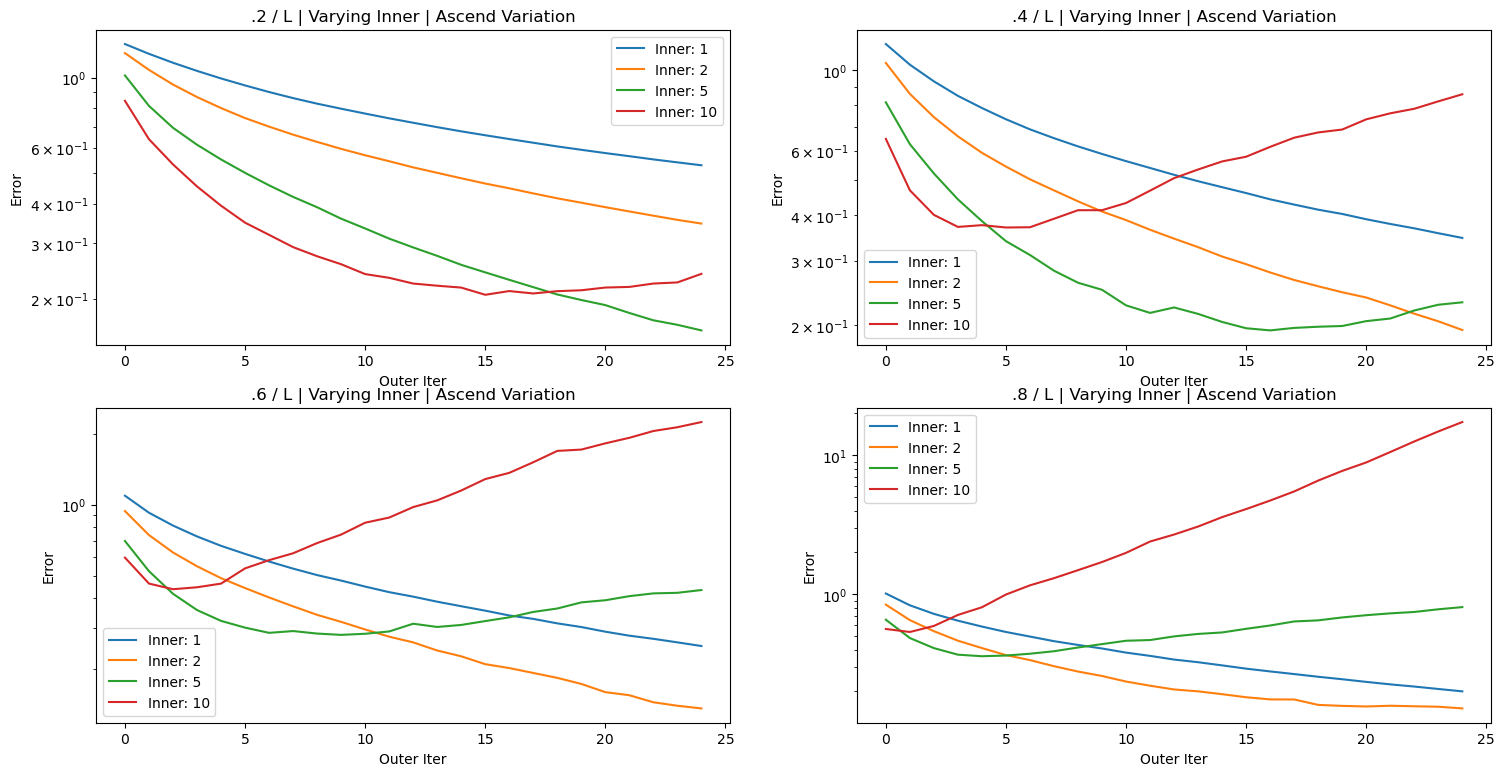

In [100]:
plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

print(".2/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingAscend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .2)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax1.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax1.set_xlabel('Outer Iter')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('.2 / L | Varying Inner | Ascend Variation')
ax1.set_yscale('log')

print(".4/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingAscend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .4)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax2.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax2.set_xlabel('Outer Iter')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('.4 / L | Varying Inner | Ascend Variation')
ax2.set_yscale('log')

print(".6/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingAscend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .6)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax3.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax3.set_xlabel('Outer Iter')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('.6 / L | Varying Inner | Ascend Variation')
ax3.set_yscale('log')


print(".8/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingAscend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .8)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax4.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax4.set_xlabel('Outer Iter')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('.8 / L | Varying Inner | Ascend Variation')
ax4.set_yscale('log')

.2/L
Min Error for Inner 1: 0.536 
Min Error for Inner 2: 0.354 
Min Error for Inner 5: 0.161 
Min Error for Inner 10: 0.22 
.4/L
Min Error for Inner 1: 0.344 
Min Error for Inner 2: 0.202 
Min Error for Inner 5: 0.2 
Min Error for Inner 10: 0.355 
.6/L
Min Error for Inner 1: 0.247 
Min Error for Inner 2: 0.134 
Min Error for Inner 5: 0.288 
Min Error for Inner 10: 0.453 
.8/L
Min Error for Inner 1: 0.191 
Min Error for Inner 2: 0.169 
Min Error for Inner 5: 0.314 
Min Error for Inner 10: 0.548 


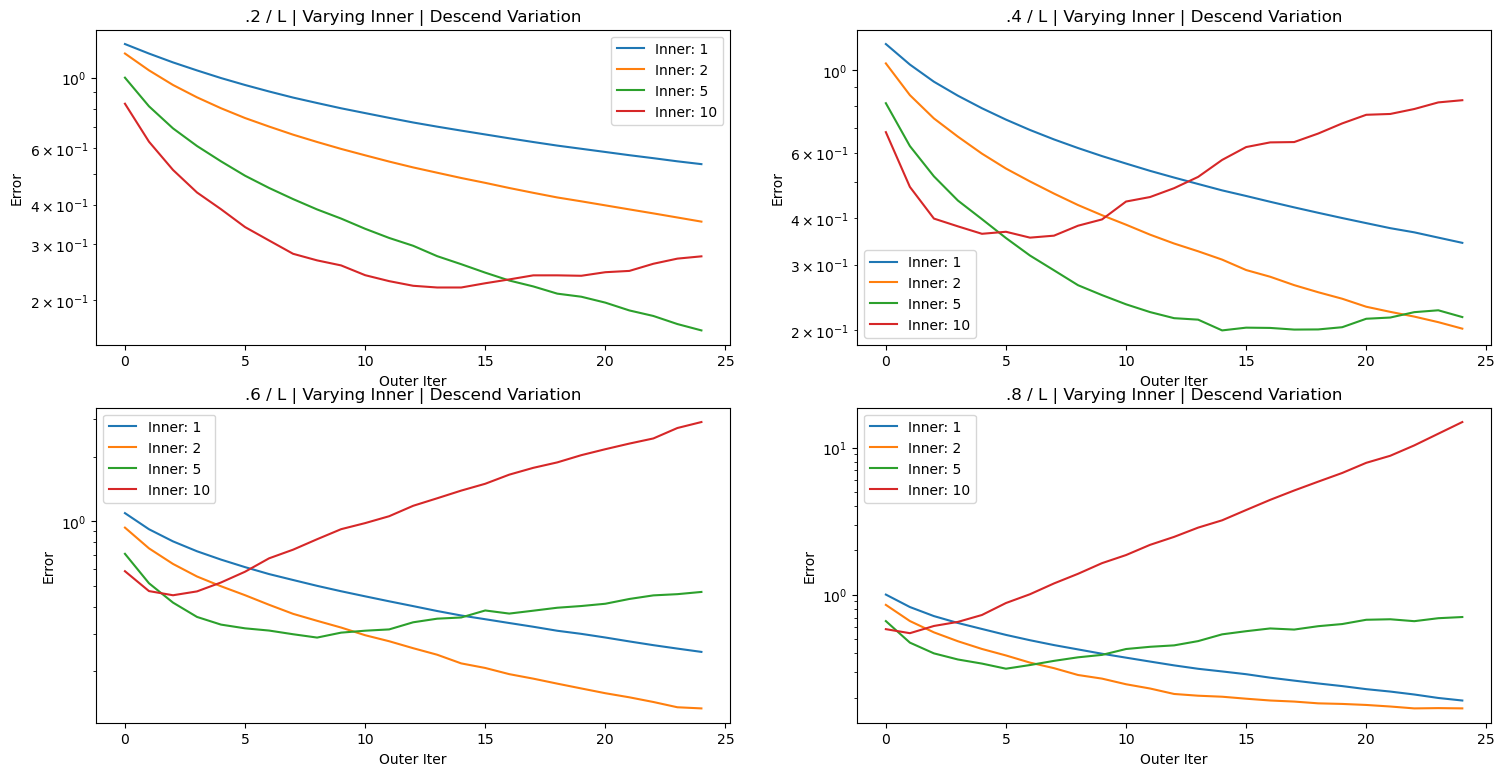

In [101]:
plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

print(".2/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingDescend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .2)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax1.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax1.set_xlabel('Outer Iter')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('.2 / L | Varying Inner | Descend Variation')
ax1.set_yscale('log')

print(".4/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingDescend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .4)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax2.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax2.set_xlabel('Outer Iter')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('.4 / L | Varying Inner | Descend Variation')
ax2.set_yscale('log')

print(".6/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingDescend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .6)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax3.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax3.set_xlabel('Outer Iter')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('.6 / L | Varying Inner | Descend Variation')
ax3.set_yscale('log')

print(".8/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingDescend(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .8)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax4.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax4.set_xlabel('Outer Iter')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('.8 / L | Varying Inner | Descend Variation')
ax4.set_yscale('log')

.2/L
Min Error for Inner 1: 0.532 
Min Error for Inner 2: 0.346 
Min Error for Inner 5: 0.164 
Min Error for Inner 10: 0.228 
.4/L
Min Error for Inner 1: 0.349 
Min Error for Inner 2: 0.204 
Min Error for Inner 5: 0.215 
Min Error for Inner 10: 0.343 
.6/L
Min Error for Inner 1: 0.247 
Min Error for Inner 2: 0.138 
Min Error for Inner 5: 0.269 
Min Error for Inner 10: 0.416 
.8/L
Min Error for Inner 1: 0.2 
Min Error for Inner 2: 0.143 
Min Error for Inner 5: 0.353 
Min Error for Inner 10: 0.488 


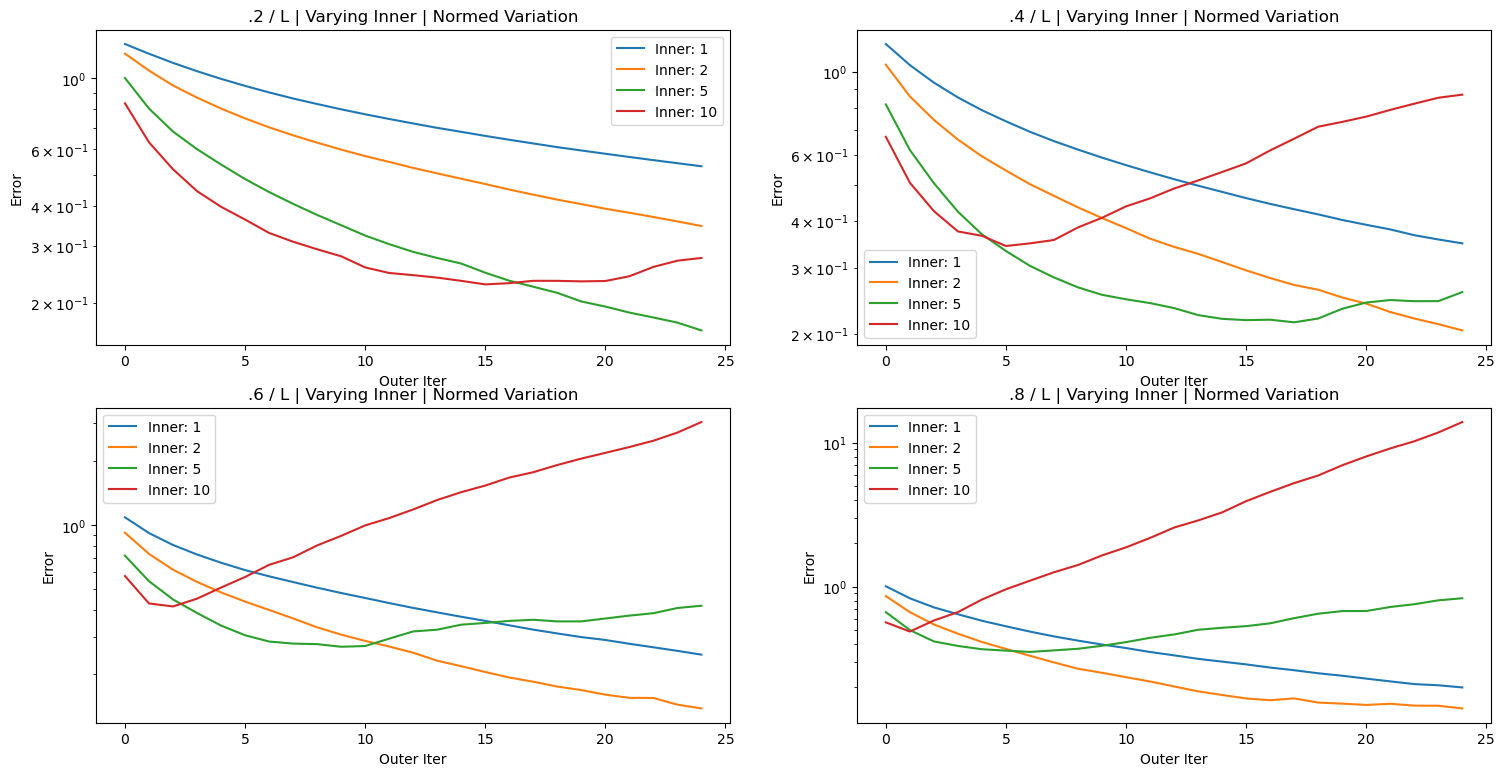

In [102]:
plt.figure(figsize=(18,9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

print(".2/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingNorm(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .2)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax1.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax1.set_xlabel('Outer Iter')
ax1.legend()
ax1.set_ylabel('Error')
ax1.set_title('.2 / L | Varying Inner | Normed Variation')
ax1.set_yscale('log')

print(".4/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingNorm(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .4)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax2.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax2.set_xlabel('Outer Iter')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('.4 / L | Varying Inner | Normed Variation')
ax2.set_yscale('log')

print(".6/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingNorm(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .6)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax3.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax3.set_xlabel('Outer Iter')
ax3.legend()
ax3.set_ylabel('Error')
ax3.set_title('.6 / L | Varying Inner | Normed Variation')
ax3.set_yscale('log')

print(".8/L")
for inner_iter_idx in range(len(inner_iter)):
    scheduling_hist = schedulingNorm(A, b, x_init, alpha, num_iter, inner_iter[inner_iter_idx], num_masks, .8)
    scheduling_err = [err(scheduling_hist[i]) for i in range(num_iter)]
    print(f"Min Error for Inner {inner_iter[inner_iter_idx]}: {round(min(scheduling_err), 3)} ")
    ax4.plot(np.arange(num_iter), scheduling_err, label= f'Inner: {inner_iter[inner_iter_idx]}')


ax4.set_xlabel('Outer Iter')
ax4.legend()
ax4.set_ylabel('Error')
ax4.set_title('.8 / L | Varying Inner | Normed Variation')
ax4.set_yscale('log')


/Users/aaronduong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Varying c | Zeta Normed')

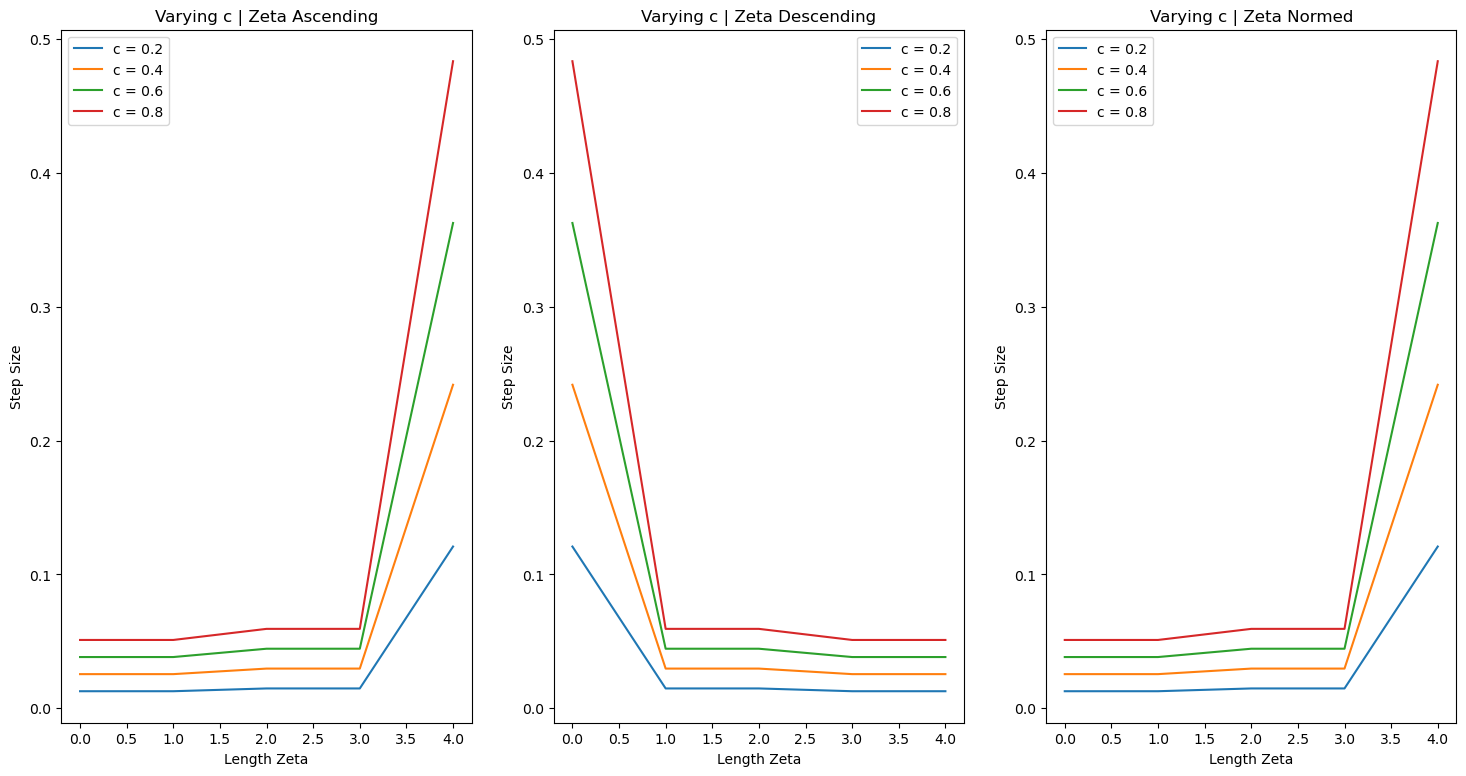

In [103]:
c = [.2, .4, .6, .8]

plt.figure(figsize=(18,9))
inner_iter = 5

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

for c_idx in range(len(c)):
    zeta1 = zetaAscend(alpha, c[c_idx] / L, inner_iter)
    zeta2 = zetaDescend(alpha, c[c_idx] / L, inner_iter)
    zeta3 = zetaNorm(alpha, c[c_idx] / L, inner_iter)

    ax1.plot(np.arange(len(zeta1)), zeta1, label= f'c = {c[c_idx]}')
    ax2.plot(np.arange(len(zeta2)), zeta2, label= f'c = {c[c_idx]}')
    ax3.plot(np.arange(len(zeta3)), zeta3, label= f'c = {c[c_idx]}')


ax1.set_xlabel('Length Zeta')
ax1.legend()
ax1.set_ylabel('Step Size')
ax1.set_title('Varying c | Zeta Ascending')


ax2.set_xlabel('Length Zeta')
ax2.legend()
ax2.set_ylabel('Step Size')
ax2.set_title('Varying c | Zeta Descending')


ax3.set_xlabel('Length Zeta')
ax3.legend()
ax3.set_ylabel('Step Size')
ax3.set_title('Varying c | Zeta Normed')



In [104]:
# import math
# alpha = .65
# num_iter = 1
# inner_iter = 1
# num_masks = 1

# eta = 0.14

# x_init = np.random.normal(size=(p,))
# x_init /= np.linalg.norm(x_init)
# x = np.copy(x_init)
# mask = sample_mask(alpha, x.shape)

# def schedulingAscend(A, b, x_init, alpha, num_iter, inner_iter, num_masks, c):
#     all_local_eta = [.14]
#     print("------- SchedulingAscend -------")
#     print("Eta Scheduling:", all_local_eta[0])
#     print("Sum x_init", sum(x_init))
#     print("Alpha", alpha)
#     print("")
#     x_hist = np.zeros((num_iter, x_init.shape[0]))
#     x = np.copy(x_init).astype(complex)
#     for i in range(num_iter):
#         x_agg = np.zeros_like(x)
#         for mask_idx in range(num_masks):
#             x_in = np.copy(x)
#             for in_iter_idx in range(inner_iter):
#                 print("----- Before x_in modification -----")
#                 print('sum masked_grad:', sum(masked_grad(A, b, x_in, mask)), '| sum reg_grad:', sum(masked_reg_grad(A, x_in, alpha, mask)), '| eta:', eta, '| sum mask', sum(mask))
#                 print("")
#                 x_in -= all_local_eta[in_iter_idx] * (masked_grad(A, b, x_in, mask)) - (alpha * masked_reg_grad(A, x_in, alpha, mask))
#                 print("----- After Modification ----")
#                 print('sum masked_grad:', sum(masked_grad(A, b, x_in, mask)), '| sum reg_grad:', sum(masked_reg_grad(A, x_in, alpha, mask)), '| eta:', eta, '| sum mask', sum(mask))
#         x = x + x_agg / num_masks
#         x_hist[i] = np.real(np.copy(x))
#     return x_hist

# def dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, inner_iter, num_masks):
#     x_hist = np.zeros((num_iter, x_init.shape[0]))
#     flag = True
#     x = np.copy(x_init)
#     for i in range(num_iter):
#         x_agg = np.zeros_like(x)
#         for mask_idx in range(num_masks):
#             x_in = np.copy(x)
#             for in_iter_idx in range(inner_iter):
#                 print('asdf', sum(b), 'masked_grad', sum(masked_grad(A, b, x_in, mask)), 'reg_grad', sum(masked_reg_grad(A, x_in, alpha, mask)), eta)
#                 x_in -= eta * masked_grad(A, b, x_in, mask) - alpha * masked_reg_grad(A, x_in, alpha, mask)
#                 print('sum masked_grad:', sum(masked_grad(A, b, x_in, mask)), '| sum reg_grad:', sum(masked_reg_grad(A, x_in, alpha, mask)), '| eta:', eta, '| sum mask', sum(mask))
#             x_agg += x_in - x
#         x = x + x_agg / num_masks
#         x_hist[i] = np.copy(x)
#     return x_hist

# schedulingAscend(A, b, x_init, alpha, num_iter, inner_iter, num_masks, 1)
# print(" ============== ")



# #plt.figure(figsize=(10, 8))
# # ----------------------------------------------------------------------


# ax1 = plt.subplot(121) #1 local iteration
# ax2 = plt.subplot(121) #1 local iteration

# dereg_dropout_err = dereg_dropout_local(A, b, x_init, eta, alpha, num_iter, 1, num_masks)
# print('t')
# dereg_local_err = [err(dereg_local_hist[i]) for i in range(num_iter)]
# ax1.plot(np.arange(num_iter), dereg_local_err, label='local = 1')

# schedulingAscend()

# ax1.set_xlabel('Global Outer')
# ax1.set_yscale('log')
# ax1.legend()
# ax1.set_ylabel('Error')
# ax1.set_title('Inner = 1')